## Import library

In [1]:
import os
import matplotlib.pyplot as plt
import random
from shutil import copyfile
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib.image import imread
import pathlib
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


In [2]:
# Cuda to used Rtx 2060
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

##  Preproccessing of Training data


In [3]:
img_width=256; img_height=256
batch_size=16
TRAINING_DIR = '../weather_pred/Data/training/'
train_datagen = ImageDataGenerator(rescale = 1/255.0)
train_generator = train_datagen.flow_from_directory(TRAINING_DIR,
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    target_size=(img_height, img_width)
                                                    )

Found 1274 images belonging to 5 classes.


##  Preproccessing of Validation data

In [4]:
VALIDATION_DIR = '../weather_pred/Data/validation/'
validation_datagen = ImageDataGenerator(rescale = 1/255.0)
validation_generator = validation_datagen.flow_from_directory(VALIDATION_DIR,
                                                              batch_size=batch_size,
                                                              class_mode='categorical',
                                                              target_size=(img_height, img_width)
                                                             )

Found 226 images belonging to 5 classes.


In [5]:
callbacks = EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='auto')
best_model_file = 'CNN_best_weights_256_without_Aug.h5'
best_model = ModelCheckpoint(best_model_file, monitor='val_acc', verbose = 1, save_best_only = True)



## Model Structure

In [6]:
model = tf.keras.models.Sequential([
    Conv2D(16, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)),
    MaxPooling2D(2, 2),
    
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    
    Conv2D(64, (3, 3), activation='relu'),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    
    Conv2D(128, (3, 3), activation='relu'),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    
    Conv2D(256, (3, 3), activation='relu'),
    Conv2D(256, (3, 3), activation='relu'),
    Conv2D(256, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    
    Flatten(),
    Dense(512, activation='relu'),
    Dense(512, activation='relu'),
    Dense(5, activation='softmax')
])



model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 58, 58, 64)        3

In [7]:
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics =['accuracy'])
history = model.fit_generator(train_generator,
                              epochs=30,
                              verbose=1,
                              validation_data=validation_generator,
                              callbacks = [best_model, callbacks]
                              )

C:\Users\Kerillos\AppData\Local\Temp\ipykernel_22348\1041231039.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator,


Epoch 1/30
80/80 [==============================] - 17s 153ms/step - loss: 1.6164 - accuracy: 0.2237 - val_loss: 1.6043 - val_accuracy: 0.2345
Epoch 2/30
80/80 [==============================] - 5s 59ms/step - loss: 1.6041 - accuracy: 0.2355 - val_loss: 1.5997 - val_accuracy: 0.2788
Epoch 3/30
80/80 [==============================] - 5s 59ms/step - loss: 1.5959 - accuracy: 0.2410 - val_loss: 1.5805 - val_accuracy: 0.2345
Epoch 4/30
80/80 [==============================] - 5s 58ms/step - loss: 1.3176 - accuracy: 0.4027 - val_loss: 1.0929 - val_accuracy: 0.4735
Epoch 5/30
80/80 [==============================] - 5s 60ms/step - loss: 1.1010 - accuracy: 0.5000 - val_loss: 0.9368 - val_accuracy: 0.5531
Epoch 6/30
80/80 [==============================] - 5s 59ms/step - loss: 1.0688 - accuracy: 0.5133 - val_loss: 0.9393 - val_accuracy: 0.5841
Epoch 7/30
80/80 [==============================] - 5s 59ms/step - loss: 0.9707 - accuracy: 0.5479 - val_loss: 0.9240 - val_accuracy: 0.5664
Epoch 8/30


## Save Model 

In [8]:
target_dir = '../weather_pred/'
if not os.path.exists(target_dir):
  os.mkdir(target_dir)
model.save(target_dir + 'CNN_model_256_without_Aug.h5')
model.save_weights(target_dir + 'CNN_weights_256_without_Aug.h5')

In [9]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc))

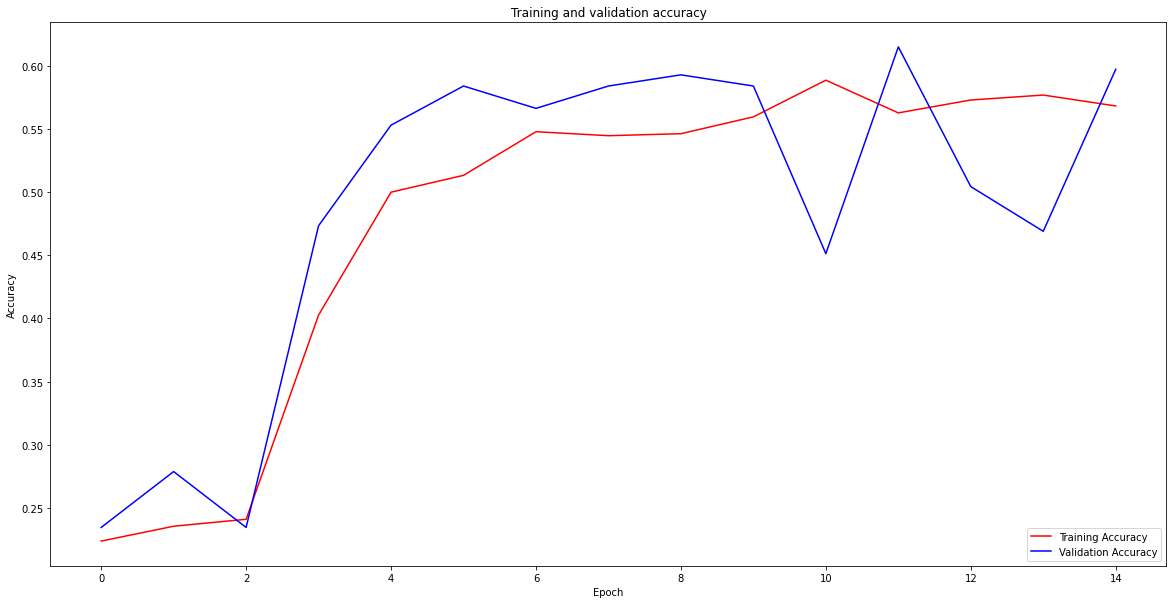

In [10]:
fig = plt.figure(figsize=(20,10))
plt.plot(epochs, acc, 'r', label="Training Accuracy")
plt.plot(epochs, val_acc, 'b', label="Validation Accuracy")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc='lower right')
plt.show()
fig.savefig('Accuracy_curve_CNN_256.jpg')

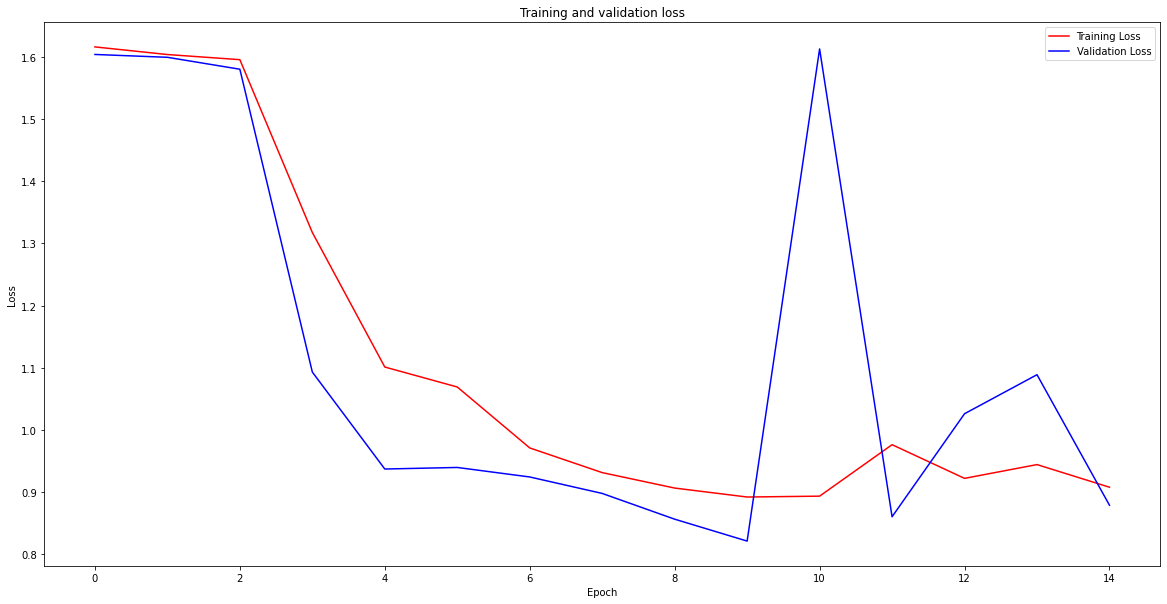

In [11]:
fig2 = plt.figure(figsize=(20,10))
plt.plot(epochs, loss, 'r', label="Training Loss")
plt.plot(epochs, val_loss, 'b', label="Validation Loss")
plt.legend(loc='upper right')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and validation loss')
fig2.savefig('Loss_curve_CNN_256.jpg')
